In [317]:
# Imports

import warnings
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as scs
import scipy.integrate as si
import seaborn as sns
import numpy.random as npr
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


# Settings

%matplotlib inline

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': (14, 7)})

# Suppress deprecation warnings.


def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


def sigmoid(x):
    '''Return value of sigmoid function (inverse of logit) at x.'''

    return 1 / (1 + np.exp(-x))

In this notebook we try to validate the derivation of the following equation:

\begin{equation}\label{int}
P(Y=0|do(R=r))=\int_x P(Y=0|T=1, X=x)P(T=1|R=r, X=x)f_x(x)~dx
\end{equation}

where $f_x(x)$ is the pdf of x. (Now $X \sim U(0, 1)$, so $f_x(x)=1$.)

First we generate data and estimate the causal effect from a causal model without unobservables Z.

0.0 % 10.0 % 20.0 % 30.0 % 40.0 % 50.0 % 60.0 % 70.0 % 80.0 % 90.0 % 
Analytical: 0.03709585053394618
Estimated:  0.035394276460008964
Difference: 0.0017015740739372148

Values for P(y=0|do(r=1)) and P(y=0|do(r=0))

Analytical: 0.14973849934787756 0.11264264881393138
Estimated:  0.14676199070433749 0.11136771424432852

Average difference: 0.00045466276498828695


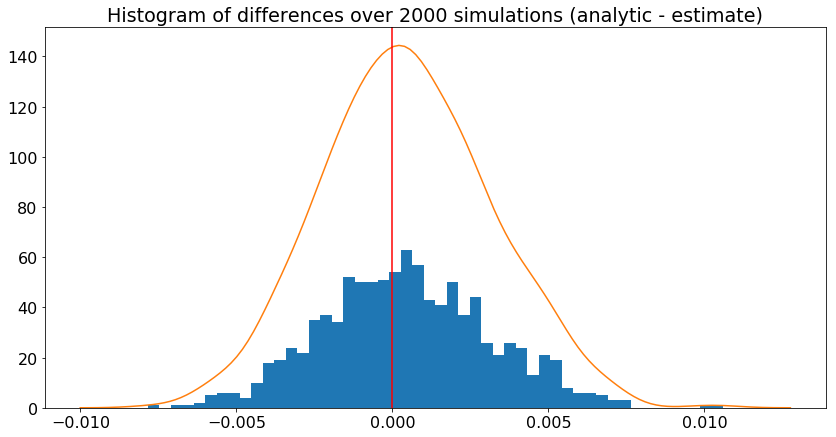

In [320]:
###
# Synthetic data 1 - without unobservables Z.

# R ~ U(0,1)
# X ~ U(0,1)
# T ~ Bin(1, sigmoid(a * r + b * x))
# Y ~ Bin(1, sigmoid(c * t + d * x)), but if T = 0 then Y = 1

# Weights for edges:
# R -> T: a
# X -> T: b
# T -> Y: c
# X -> Y: d

N = 12000
a = 1
b = 1
c = 1
d = 1


def generateData(N=N, a=a, b=b, c=c, d=d):

    r = npr.uniform(size=N)
    x = npr.uniform(size=N)

    t = npr.binomial(n=1, p=sigmoid(a * r + b * x), size=N)

    y = npr.binomial(n=1, p=sigmoid(c * t + d * x), size=N)

    # If decision is negative, we set Y to positive.
    y[t == 0] = 1

    return r, x, t, y


def analytic_R_on_Y(r, a, b, c, d):
    '''Return probability of Y=0 with given parameters.'''

    # P(y=0|t=1, x) * p(t=1|r, x) * p(x)
    t_1 = si.quad(
        lambda x: (1 - sigmoid(c * 1 + d * x)) * sigmoid(a * r + b * x) * 1, 0,
        1)

    # P(y=0|t=0, x) * p(t=0|r, x) * p(x)
    # Now equal to 0, hence commented out. Y=0 and T=0 mutually exclusive.
    t_0 = si.quad(
        lambda x: (1 - sigmoid(c * 0 + d * x)) * (1 - sigmoid(a * r + b * x)) *
        1, 0, 1)

    return t_1[0]  # + t_0[0]

# Calculate the difference between the analytic value and an estimate obtained 
# from synthetic data.

diffs = np.zeros(0)

for i in range(1000):

    r, x, t, y = generateData()

    # Fit predictive models.
    lr_t = LogisticRegression(solver='lbfgs')
    lr_y = LogisticRegression(solver='lbfgs')

    lr_t = lr_t.fit(np.array([r, x]).T, t)
    lr_y = lr_y.fit(np.array([t, x]).T, y)

    def causal_effect_of_R_on_Y(r):

        # Integrate P(Y=0|T=1, X=x) * P(T=1|R=r, X=x) * f(x) from 0 to 1
        return si.quad(
            lambda x: lr_y.predict_proba(np.array([[1, x]]))[0, 0] * lr_t.
            predict_proba(np.array([[r, x]]))[0, 1], 0, 1)

    r0 = causal_effect_of_R_on_Y(0)
    r1 = causal_effect_of_R_on_Y(1)

    analytical = analytic_R_on_Y(1, a, b, c, d) - \
        analytic_R_on_Y(0, a, b, c, d)

    diffs = np.append(diffs, analytical - r1[0] + r0[0])

    if i % 100 == 0:
        print(i / 10, "%", end=" ")

print()
print("Analytical:", analytical)
print("Estimated: ", r1[0] - r0[0])
print("Difference:", analytical - r1[0] + r0[0])
print()
print("Values for P(y=0|do(r=1)) and P(y=0|do(r=0))\n")
print("Analytical:", analytic_R_on_Y(1, a, b, c, d),
      analytic_R_on_Y(0, a, b, c, d))
print("Estimated: ", r1[0], r0[0])
print()
print("Average difference:", np.mean(diffs))
plt.hist(diffs, bins=50)
plt.title("Histogram of differences over 2000 simulations (analytic - estimate)")
sns.kdeplot(diffs)
plt.axvline(x=0, c='r')

It can be observed that when there are no unobservables, the causal effect $$P(Y=0|do(R=r))=\int_x P(Y=0|T=1, X=x)P(T=1|R=r, X=x)f_x(x)~dx$$ can be estimated without bias.

Next we generate data and estimate the causal effect from a causal model with unobservables Z. 

Z influences both T and Y.

0.0 % 10.0 % 20.0 % 30.0 % 40.0 % 50.0 % 60.0 % 70.0 % 80.0 % 90.0 % 
Analytical: 0.02047548901524536
Estimated:  0.01934600091154902

Values for P(y=0|do(r=1)) and P(y=0|do(r=0))

Analytical: 0.10799301700601992 0.08751752799077456
Estimated:  0.11028400555152502 0.090938004639976

Average difference: 0.0013544947748748567
Std of differences: 0.0016880435339749395


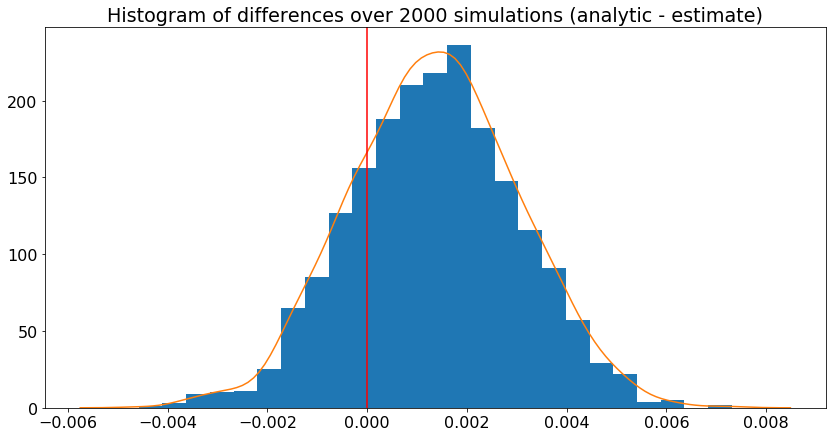

In [319]:
###
# Synthetic data 2 - with unobservable Z

# R ~ U(0,1)
# X ~ U(0,1)
# Z ~ U(0,1)
# T ~ Bin(1, sigmoid(a * r + b * x + e * z))
# Y ~ Bin(1, sigmoid(c * t + d * x + f * z))

# Weights for edges:
# R -> T: a
# X -> T: b
# T -> Y: c
# X -> Y: d
# Z -> T: e
# Z -> Y: f

N = 12000
a = 1
b = 1
c = 1
d = 1
e = 1
f = 1


def generateDataWithZ(N=N, a=a, b=b, c=c, d=d, e=e, f=f):

    r = npr.uniform(size=N)
    x = npr.uniform(size=N)
    z = npr.uniform(size=N)

    t = npr.binomial(n=1, p=sigmoid(a * r + b * x + e * z), size=N)

    y = npr.binomial(n=1, p=sigmoid(c * t + d * x + f * z), size=N)

    # If decision is negative, we set Y to positive.
    y[t == 0] = 1

    return r, x, z, t, y


def analytic_R_on_Y(r, a, b, c, d, e, f):
    '''Return probability of Y=0 with given parameters.'''

    # P(y=0|T=t, x, z) * p(T=t|r, x, z) * p(x) * p(z)
    def integrand(t, x, z):
        p_y0 = 1 - sigmoid(c * t + d * x + f * z)

        if t == 1:
            p_t = sigmoid(a * r + b * x + e * z)
        elif t == 0:
            p_t = 1 - sigmoid(a * r + b * x + e * z)

        p_x = 1
        
        p_z = 1

        return p_y0 * p_t * p_x * p_z

    t_1 = si.dblquad(lambda x, z: integrand(1, x, z), 0,
                     1, lambda x: 0, lambda x: 1)

    # P(y=0|t=0, x) * p(t=0|r, x) * p(x)
    # Now equal to 0, hence commented out. See data generation.
    t_0 = si.dblquad(lambda x, z: integrand(0, x, z), 0,
                     1, lambda x: 0, lambda x: 1)

    return t_1[0]  # + t_0[0]


diffs = np.zeros(0)

for i in range(2000):

    r, x, z, t, y = generateDataWithZ()

    # Fit predictive models.
    lr_t = LogisticRegression(solver='lbfgs')
    lr_y = LogisticRegression(solver='lbfgs')

    lr_t = lr_t.fit(np.array([r, x]).T, t)
    lr_y = lr_y.fit(np.array([t, x]).T, y)

    def causal_effect_of_R_on_Y(r):

        # Integrate P(Y=0|T=1, X=x) * P(T=1|R=r, X=x) * f(x) from 0 to 1
        return (si.quad(
            lambda x: lr_y.predict_proba(np.array([[1, x]]))[0, 0] * lr_t.
            predict_proba(np.array([[r, x]]))[0, 1], 0, 1))

    r0 = causal_effect_of_R_on_Y(0)
    r1 = causal_effect_of_R_on_Y(1)

    analytical = analytic_R_on_Y(1, a, b, c, d, e, f) - analytic_R_on_Y(
        0, a, b, c, d, e, f)

    diffs = np.append(diffs, analytical - r1[0] + r0[0])

    if i % 200 == 0:
        print(i / 20, "%", end=" ")

print()
print("Analytical:", analytical)
print("Estimated: ", r1[0] - r0[0])
print()
print("Values for P(y=0|do(r=1)) and P(y=0|do(r=0))\n")
print("Analytical:", analytic_R_on_Y(1, a, b, c, d, e, f),
      analytic_R_on_Y(0, a, b, c, d, e, f))
print("Estimated: ", r1[0], r0[0])
print()
print("Average difference:", np.mean(diffs))
print("Std of differences:", np.std(diffs))
plt.hist(diffs, bins=25)
plt.title("Histogram of differences over 2000 simulations (analytic - estimate)")
sns.kdeplot(diffs)
plt.axvline(x=0, c='r')

Now it is visible that the quantity $P(Y=0|do(R=r))$ is slightly biased when estimated with equation \ref{int}.


According to [Pearl's Theorem 3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2836213/): "A *sufficient* condition for identifying the causal effect P(y|do(x)) is that every path between X and any of its children traces at least one arrow emanating from a measured variable."